<a href="https://colab.research.google.com/github/deivisongithub/OCR_for_numbers/blob/main/OCR_Guaraves_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Escaneamento de imagem do painel Guaraves (UFPB)

# Importando as bibliotecas

In [ ]:
import numpy as np
import cv2
import imutils
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import PIL
from PIL import Image
import os

# Capturando tela (deverá ser a partir da camera)



In [ ]:
!wget https://i.postimg.cc/m2y9Gnzw/guaraves.jpg ./

--2021-11-20 14:17:58--  https://i.postimg.cc/m2y9Gnzw/guaraves.jpg
Resolving i.postimg.cc (i.postimg.cc)... 5.135.83.165, 51.91.224.95, 141.94.130.128
Connecting to i.postimg.cc (i.postimg.cc)|5.135.83.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169356 (165K) [image/jpeg]
Saving to: ‘guaraves.jpg.1’

guaraves.jpg.1      100%[===================>] 165.39K   712KB/s    in 0.2s    

2021-11-20 14:17:58 (712 KB/s) - ‘guaraves.jpg.1’ saved [169356/169356]

--2021-11-20 14:17:58--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-11-20 14:17:58--
Total wall clock time: 0.6s
Downloaded: 1 files, 165K in 0.2s (712 KB/s)


In [ ]:
def mostrar(img):
  fig = plt.gcf()
  fig.set_size_inches(20, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

# Processamentos na imagem (enquadramento da tela)

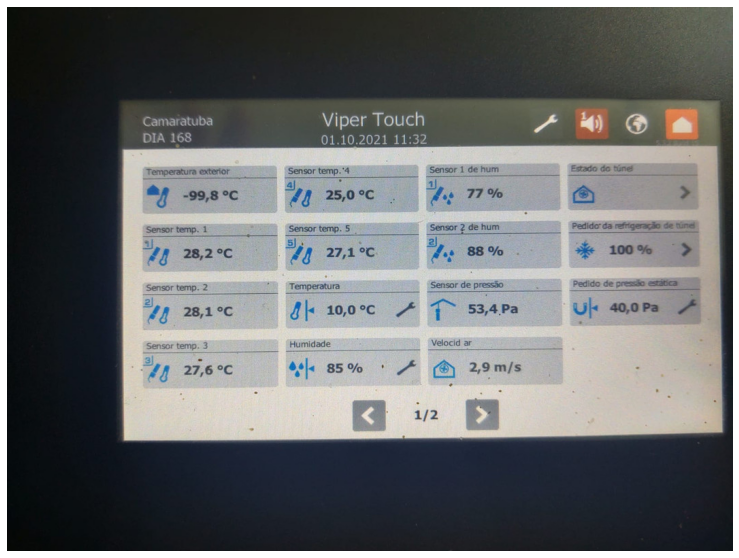

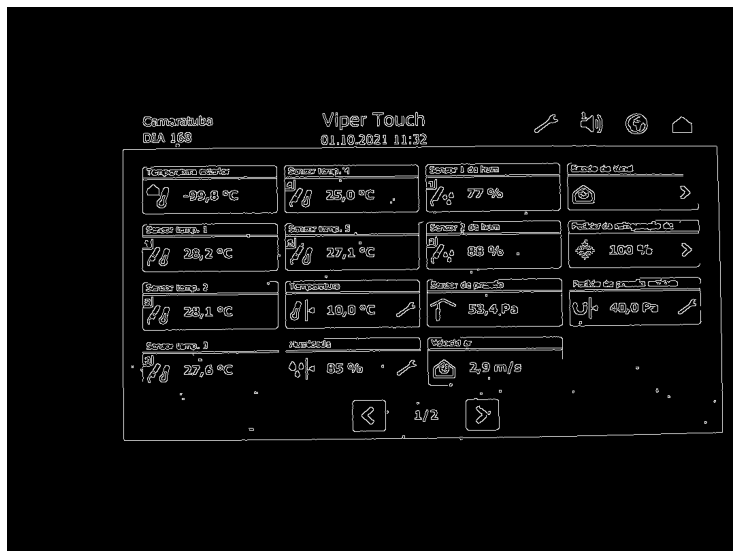

In [ ]:
img = cv2.imread('guaraves.jpg')
original = img.copy()
mostrar(img)
(H, W) = img.shape[:2]

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blur = cv2.GaussianBlur(gray, (3, 3), 0)

edged = cv2.Canny(blur, 60, 160)

mostrar(edged)

# Detecção de contornos na imagem

In [ ]:
def encontrar_contornos(img):
  conts = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  conts = imutils.grab_contours(conts)
  conts = sorted(conts, key = cv2.contourArea, reverse = True)[:6]
  return conts

conts = encontrar_contornos(edged.copy())

## Localizando o maior contorno



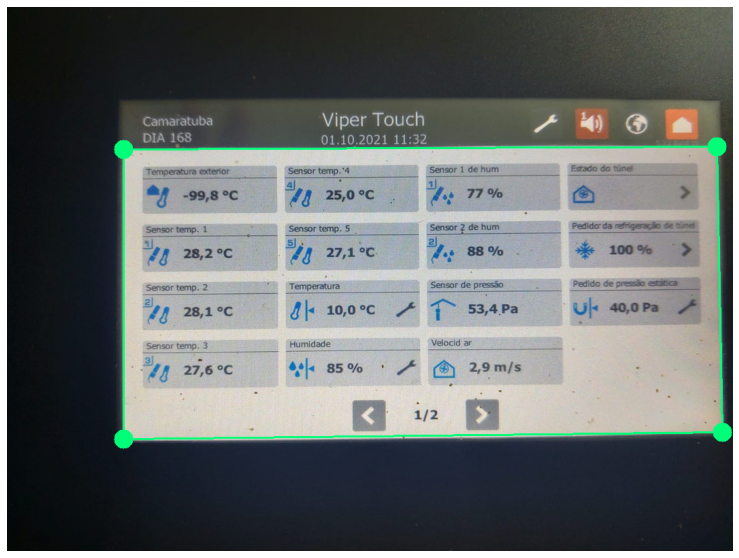

In [ ]:
for c in conts:
  perimetro = cv2.arcLength(c, True)
  aproximacao = cv2.approxPolyDP(c, 0.02 * perimetro, True)
  if len(aproximacao) == 4:
    maior = aproximacao
    break

cv2.drawContours(img, maior, -1, (120, 255, 0), 28)
cv2.drawContours(img, [maior], -1, (120, 255, 0), 2)
mostrar(img)

##Transformação geométrica

In [ ]:
def ordenar_pontos(pontos):
  pontos = pontos.reshape((4,2))
  pontos_novos = np.zeros((4, 1, 2), dtype=np.int32)

  add = pontos.sum(1)
  pontos_novos[0] = pontos[np.argmin(add)]
  pontos_novos[2] = pontos[np.argmax(add)]

  dif = np.diff(pontos, axis = 1)
  pontos_novos[1] = pontos[np.argmin(dif)]
  pontos_novos[3] = pontos[np.argmax(dif)]

  return pontos_novos

pontos_maior = ordenar_pontos(maior)
#print(pontos_maior)

Obtenção da matriz de transformação

In [ ]:
pts1 = np.float32(pontos_maior)

In [ ]:
pts2 = np.float32([[0,0], [W, 0], [W, H], [0, H]])

In [ ]:
matriz = cv2.getPerspectiveTransform(pts1, pts2)
#matriz

Transformação de perspectiva

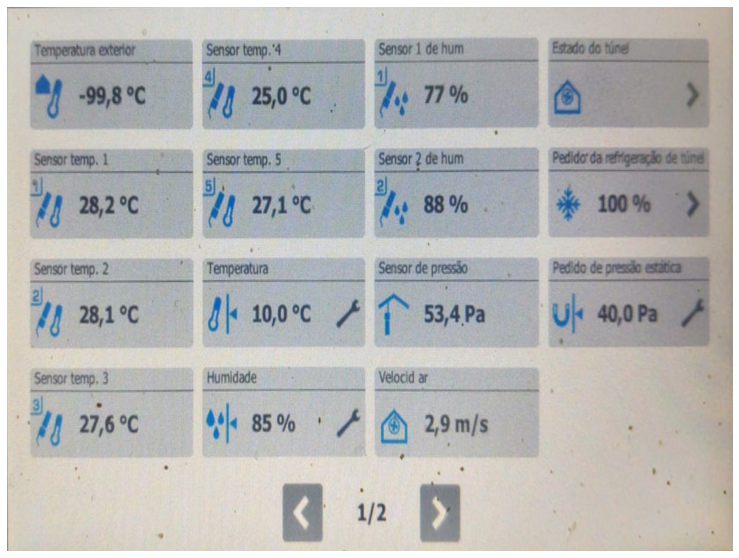

In [ ]:
transform = cv2.warpPerspective(original, matriz, (W, H))

mostrar(transform) 

### Métricas de pixels da imagem

                                   aspect-ratio:   auto 725 / 547;
                                 

                                      width box:   163px;       22.4%
                                     height box:   90px;        12.4% 
                                 box proportion:   163 / 90;

                                          width:   725px;

                    width from left edge to box:   26px;        3.58%
                   width from right edge to box:   26px;        3.58%
                   width last box to right edge:   196px;       27.03%
                               width box to box:   12px;        1.65%

                                         height:   547px;

                              height box to box:   23px;        4.20%
             height from upper limit to the box:   35px;        6.39%
             height from lower limit to the box:   97px;        17.73%
    height from lower limit to the farthest box:   205px;       37.47%







#Segmentação

(função para binarizar a imagem com o opencv)

In [ ]:
def preprocessamento(img):
  maior = cv2.resize(img, None, fx=3.4, fy=3.4, interpolation=cv2.INTER_CUBIC)
  valor, otsu = cv2.threshold(maior, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  return otsu



(Falta automatizar esta parte)

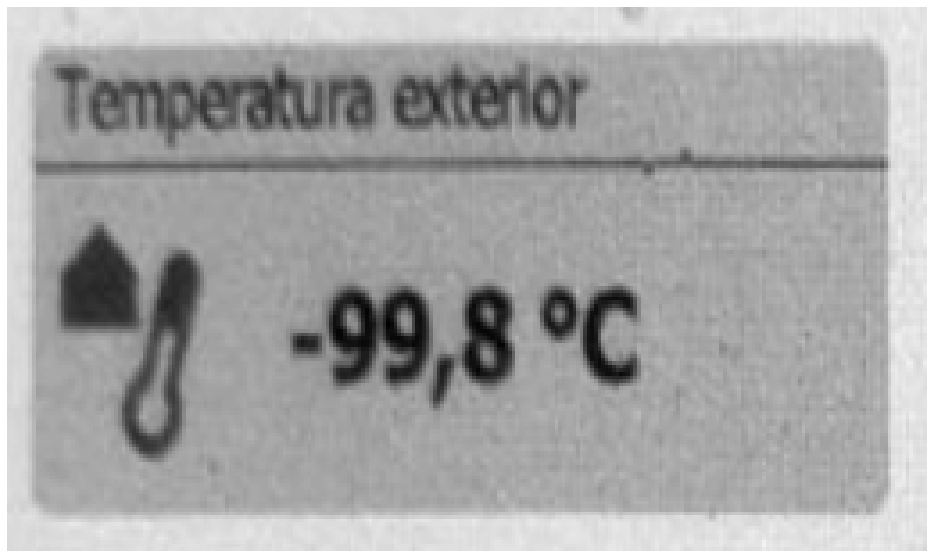

In [ ]:
#x1 = 85
#x2 = 230
#y1 = 110
#y2 = 160
x1 = 27
x2 = 284
y1 = 38
y2 = 190
#Temperatura_exterior = np.array([[[ x1,  y1]], [[x1,  y2]], [[x2,  y2]], [[x2,  y1]]])
#cv2.drawContours(transform, [Temperatura_exterior], -1, (250, 20, 20), 2)



janela=transform[y1:y2, x1:x2]
janelaBW=cv2.cvtColor(janela, cv2.COLOR_BGR2GRAY)

janelaBW = np.around((janelaBW-48)*1.4)
janelaBW = janelaBW.astype(np.uint8)
mostrar(janelaBW)

## Seguimentação automatizada


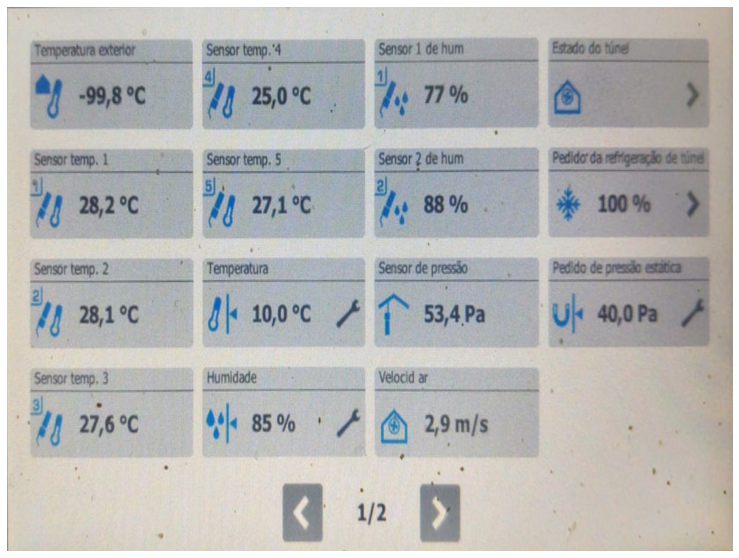

In [ ]:
mostrar(transform)

### Função que retorna as dimenções de uma imagem

In [ ]:
def get_image_dimensions(imagefile):
    """
    Helper function that returns the image dimentions

    :param: imagefile str (path to image)
    :return dict (of the form: {width:<int>, height=<int>, size_bytes=<size_bytes>)
    """
    # Inline import for PIL because it is not a common library
    with Image.open(imagefile) as img:
        # Calculate the width and hight of an image
        width, height = img.size

    # calculat ethe size in bytes
    size_bytes = os.path.getsize(imagefile)

    return dict(width=width, height=height, size_bytes=size_bytes)

In [ ]:
#dimensions = get_image_dimensions('teste.png')

In [ ]:
dimensions = {'width': 739, 'height': 558, 'size_bytes': 600572}

In [ ]:
print(dimensions)

{'width': 739, 'height': 558, 'size_bytes': 600572}


In [ ]:
'''
x1 = int(((85/739) * dimensions['width']) // 1)
x1_add = int(((260/739) * dimensions['width']) // 1)

x2 = int(((230/739) * dimensions['width']) // 1)
x2_add = int(((250/739) * dimensions['width']) // 1)

y1 = int(((110/558) * dimensions['height']) // 1)
y1_add = int(((150/558) * dimensions['height']) // 1)

y2 = int(((160/558) * dimensions['height']) // 1)
y2_add = int(((160/558) * dimensions['height']) // 1)

for i in range(4):
  x1 = int(((85/739) * dimensions['width']) // 1)
  x2 = int(((230/739) * dimensions['width']) // 1)
  if i > 0:
    y1 = y1 + y1_add
    y2 = y2 + y2_add
  
  for j in range(4):
    if i == 0 and j == 3:
      break
    if i == 3 and j == 3:
      break
    if j > 0:
      x1 = x1 + x1_add
      x2 = x2 + x2_add

    janela=transform[y1:y2, x1:x2]
    janelaBW=cv2.cvtColor(janela, cv2.COLOR_BGR2GRAY)

    janelaBW = np.around((janelaBW-48)*1.4)
    janelaBW = janelaBW.astype(np.uint8)
    mostrar(janelaBW)
    '''

"\nx1 = int(((85/739) * dimensions['width']) // 1)\nx1_add = int(((260/739) * dimensions['width']) // 1)\n\nx2 = int(((230/739) * dimensions['width']) // 1)\nx2_add = int(((250/739) * dimensions['width']) // 1)\n\ny1 = int(((110/558) * dimensions['height']) // 1)\ny1_add = int(((150/558) * dimensions['height']) // 1)\n\ny2 = int(((160/558) * dimensions['height']) // 1)\ny2_add = int(((160/558) * dimensions['height']) // 1)\n\nfor i in range(4):\n  x1 = int(((85/739) * dimensions['width']) // 1)\n  x2 = int(((230/739) * dimensions['width']) // 1)\n  if i > 0:\n    y1 = y1 + y1_add\n    y2 = y2 + y2_add\n  \n  for j in range(4):\n    if i == 0 and j == 3:\n      break\n    if i == 3 and j == 3:\n      break\n    if j > 0:\n      x1 = x1 + x1_add\n      x2 = x2 + x2_add\n\n    janela=transform[y1:y2, x1:x2]\n    janelaBW=cv2.cvtColor(janela, cv2.COLOR_BGR2GRAY)\n\n    janelaBW = np.around((janelaBW-48)*1.4)\n    janelaBW = janelaBW.astype(np.uint8)\n    mostrar(janelaBW)\n    "

#Reconhecimento de caracteres

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract 
import pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (26.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5

In [ ]:
!mkdir tessdata
!#wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true

!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/raw/4.00/por.traineddata

--2021-11-20 14:18:15--  https://github.com/tesseract-ocr/tessdata/raw/4.00/por.traineddata
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tesseract-ocr/tessdata/4.00/por.traineddata [following]
--2021-11-20 14:18:16--  https://raw.githubusercontent.com/tesseract-ocr/tessdata/4.00/por.traineddata
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21457953 (20M) [application/octet-stream]
Saving to: ‘./tessdata/por.traineddata’

./tessdata/por.trai 100%[===================>]  20.46M  --.-KB/s    in 0.1s    

2021-11-20 14:18:17 (183 MB/s) - ‘./tessdata/por.traineddata’ saved [21457953/21457953]



In [ ]:
'''
x1 = int(((85/739) * dimensions['width']) // 1)
x1_add = int(((260/739) * dimensions['width']) // 1)

x2 = int(((230/739) * dimensions['width']) // 1)
x2_add = int(((250/739) * dimensions['width']) // 1)

y1 = int(((110/558) * dimensions['height']) // 1)
y1_add = int(((150/558) * dimensions['height']) // 1)

y2 = int(((160/558) * dimensions['height']) // 1)
y2_add = int(((160/558) * dimensions['height']) // 1)

for i in range(4):
  x1 = int(((85/739) * dimensions['width']) // 1)
  x2 = int(((230/739) * dimensions['width']) // 1)
  if i > 0:
    y1 = y1 + y1_add
    y2 = y2 + y2_add
  
  for j in range(4):
    if i == 0 and j == 3:
      break
    if i == 3 and j == 3:
      break
    if j > 0:
      x1 = x1 + x1_add
      x2 = x2 + x2_add

    janela=transform[y1:y2, x1:x2]
    janelaBW=cv2.cvtColor(janela, cv2.COLOR_BGR2GRAY)

    janelaBW = np.around((janelaBW-48)*1.4)
    janelaBW = janelaBW.astype(np.uint8)
    '''
    

"\nx1 = int(((85/739) * dimensions['width']) // 1)\nx1_add = int(((260/739) * dimensions['width']) // 1)\n\nx2 = int(((230/739) * dimensions['width']) // 1)\nx2_add = int(((250/739) * dimensions['width']) // 1)\n\ny1 = int(((110/558) * dimensions['height']) // 1)\ny1_add = int(((150/558) * dimensions['height']) // 1)\n\ny2 = int(((160/558) * dimensions['height']) // 1)\ny2_add = int(((160/558) * dimensions['height']) // 1)\n\nfor i in range(4):\n  x1 = int(((85/739) * dimensions['width']) // 1)\n  x2 = int(((230/739) * dimensions['width']) // 1)\n  if i > 0:\n    y1 = y1 + y1_add\n    y2 = y2 + y2_add\n  \n  for j in range(4):\n    if i == 0 and j == 3:\n      break\n    if i == 3 and j == 3:\n      break\n    if j > 0:\n      x1 = x1 + x1_add\n      x2 = x2 + x2_add\n\n    janela=transform[y1:y2, x1:x2]\n    janelaBW=cv2.cvtColor(janela, cv2.COLOR_BGR2GRAY)\n\n    janelaBW = np.around((janelaBW-48)*1.4)\n    janelaBW = janelaBW.astype(np.uint8)\n    "

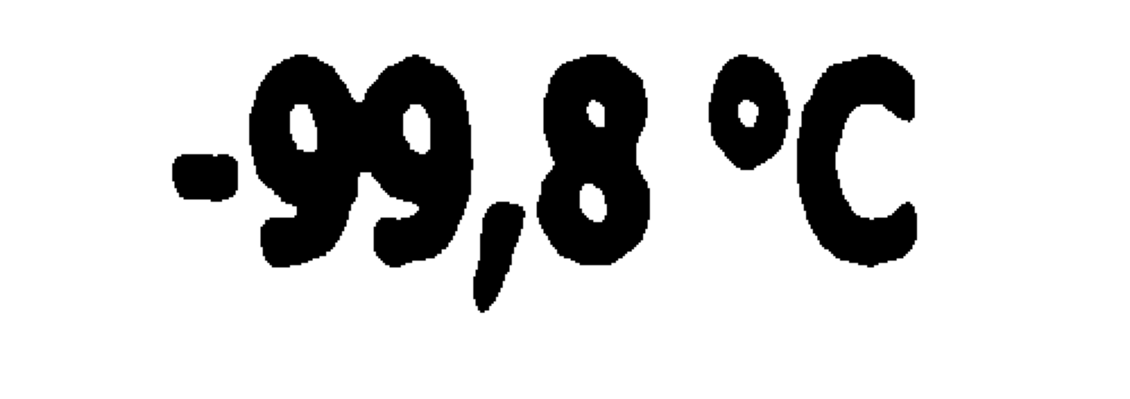

-99,8 °C



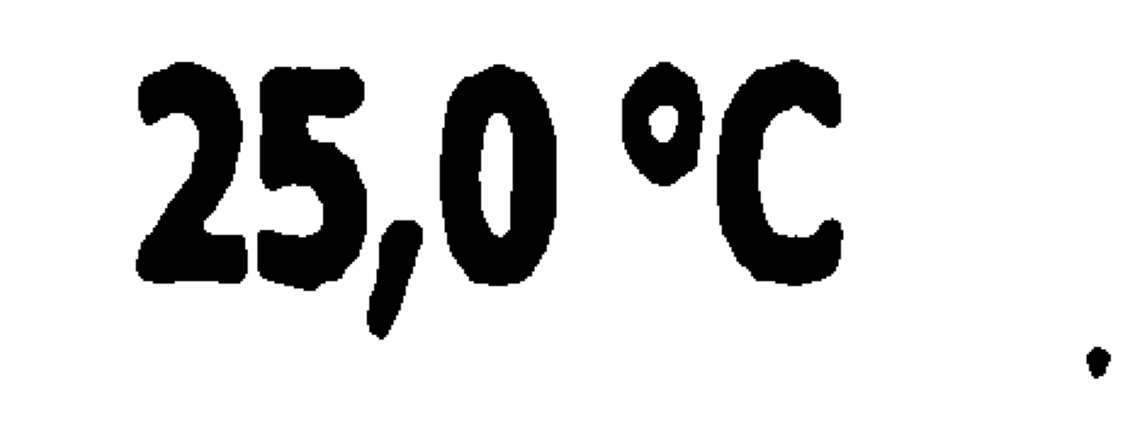

25,0 °C



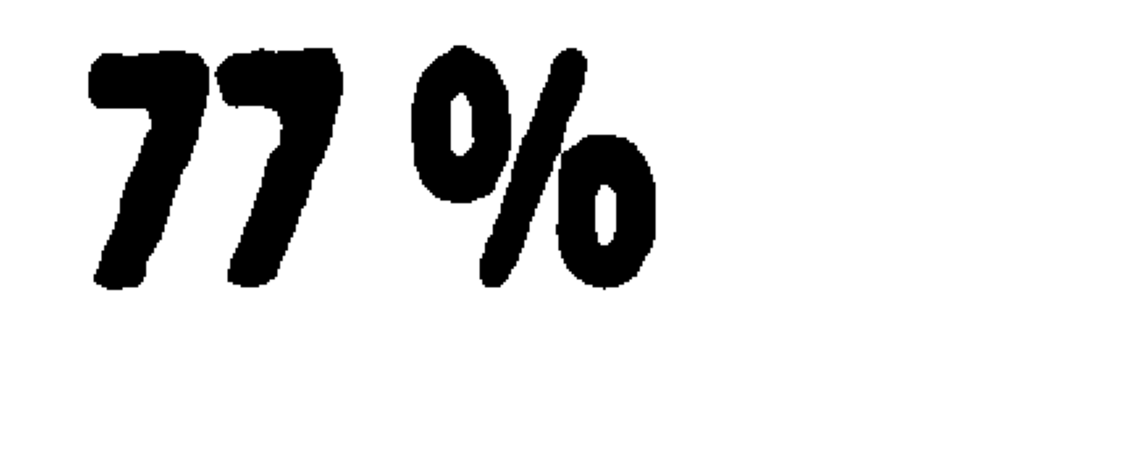

77%



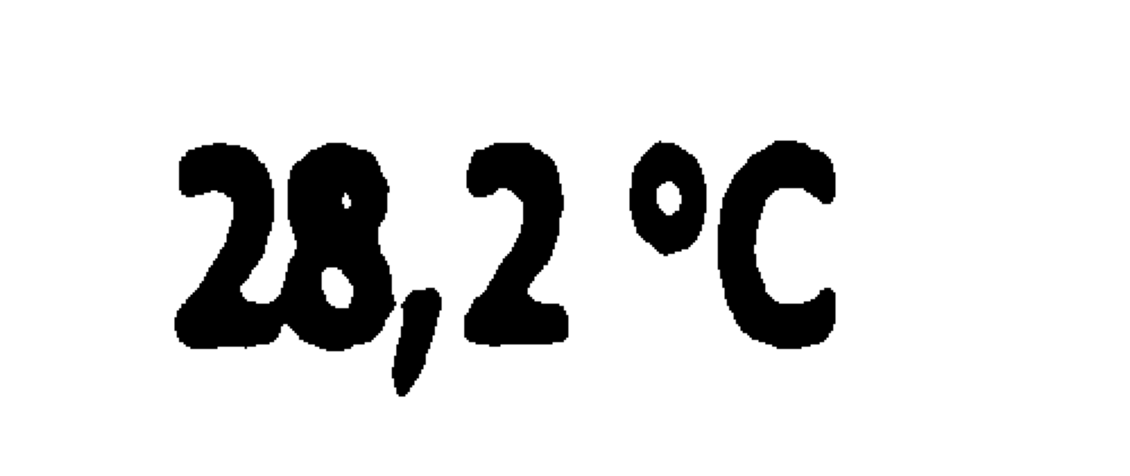

28,2 °C



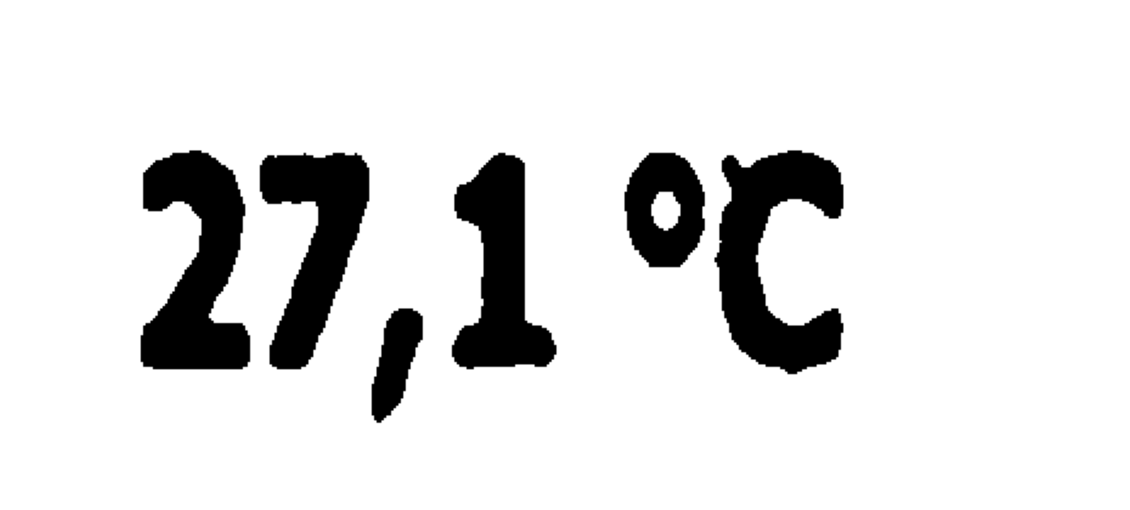

27,1°C



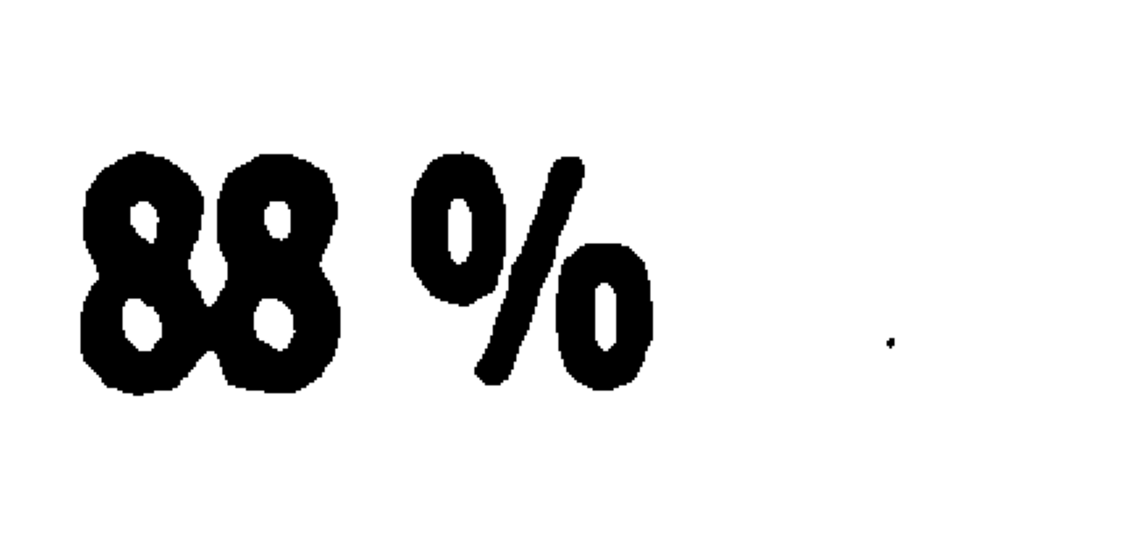

88% .



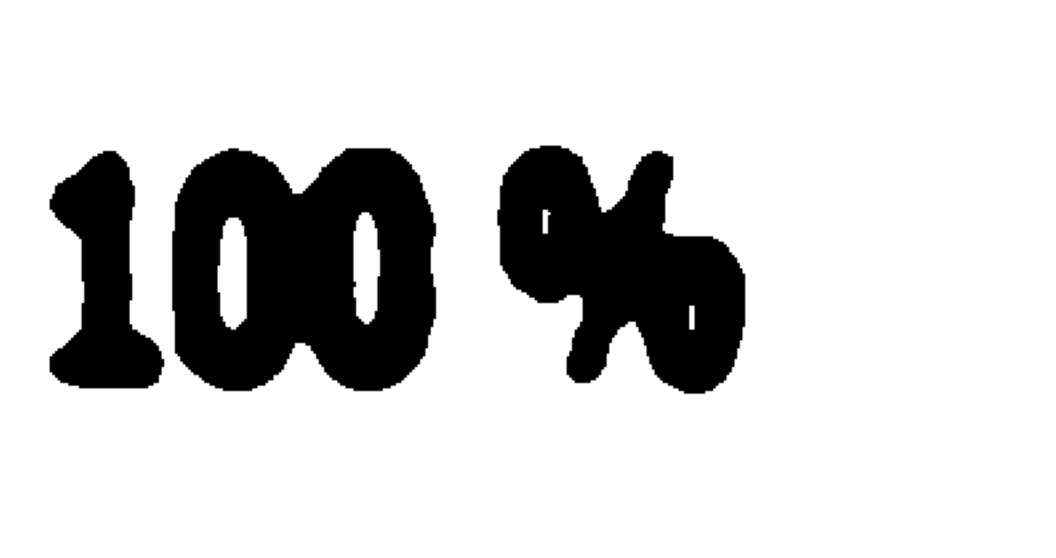

100 %



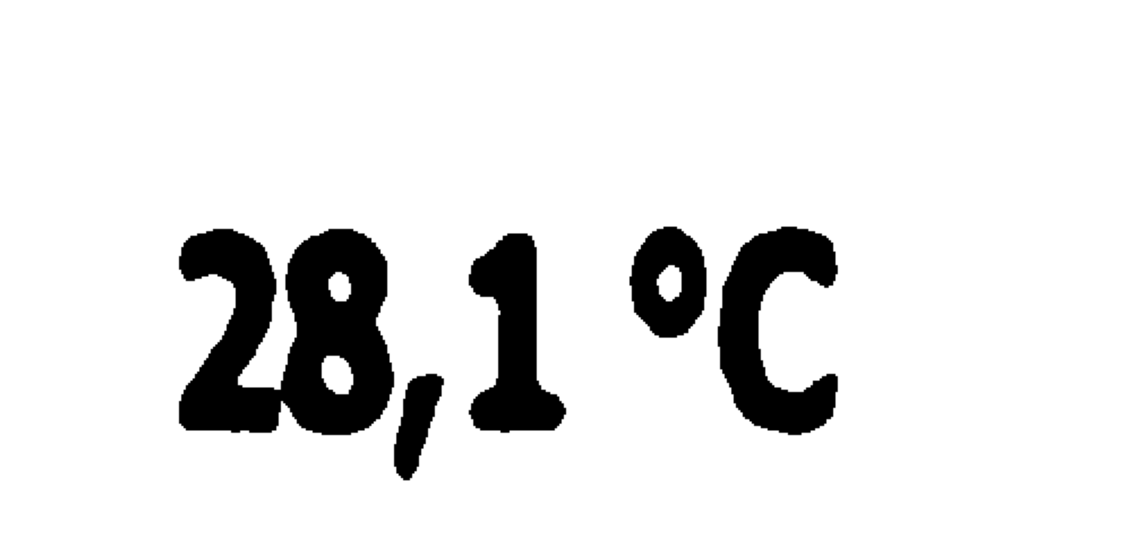

28,1 °C



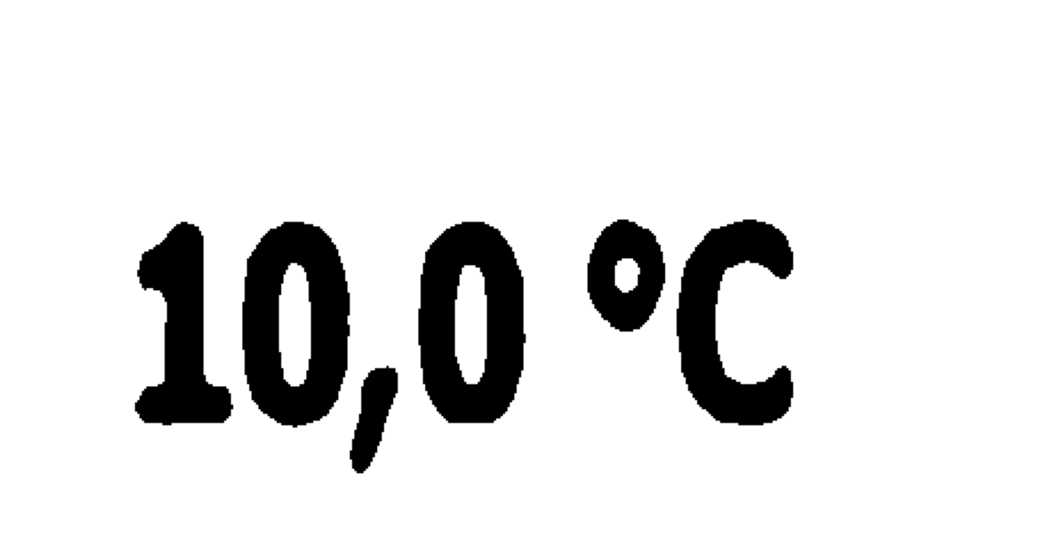

10,0 °C



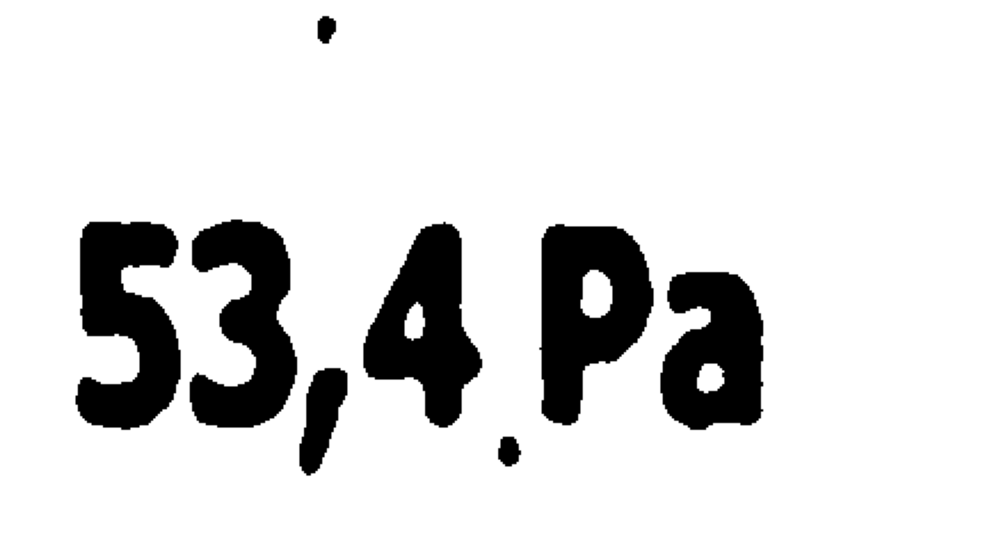

53,4 Pa



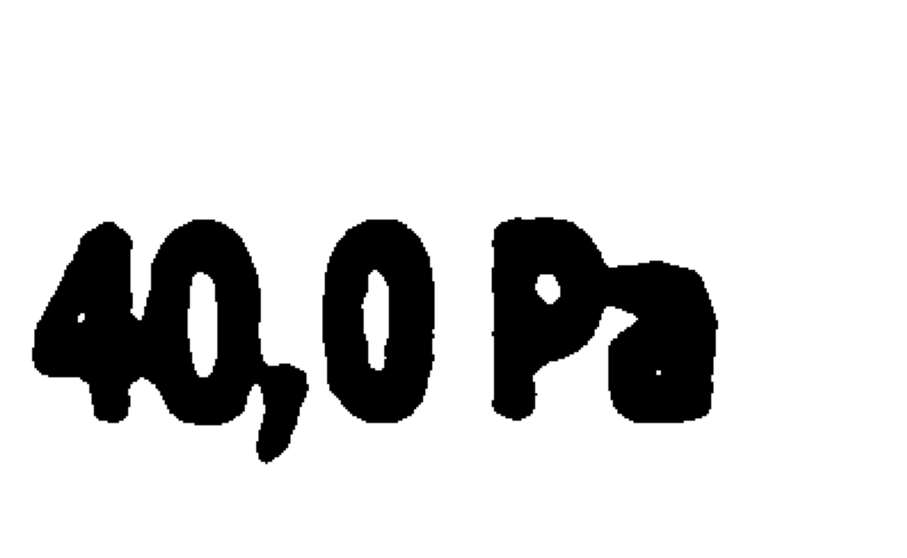

40,0 Pa



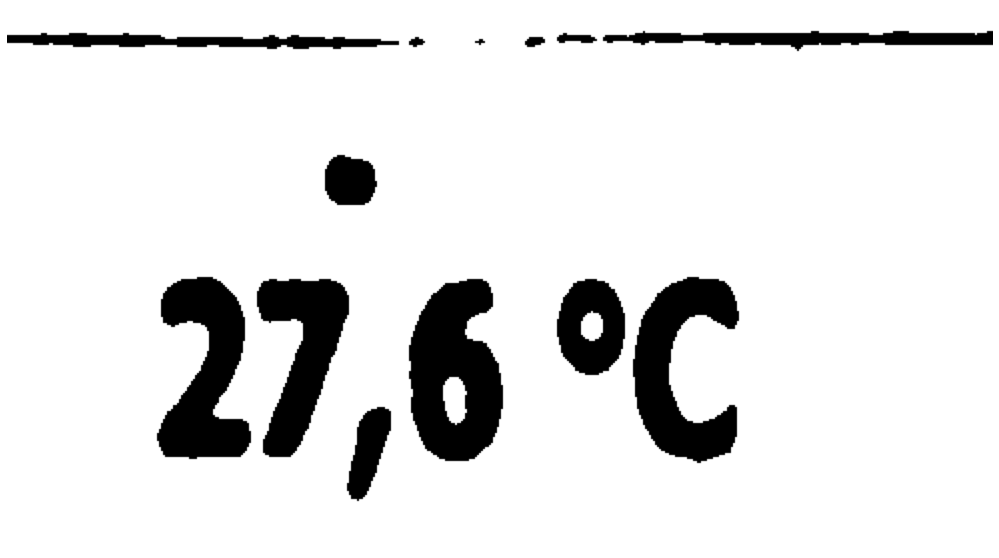

27,6 °C



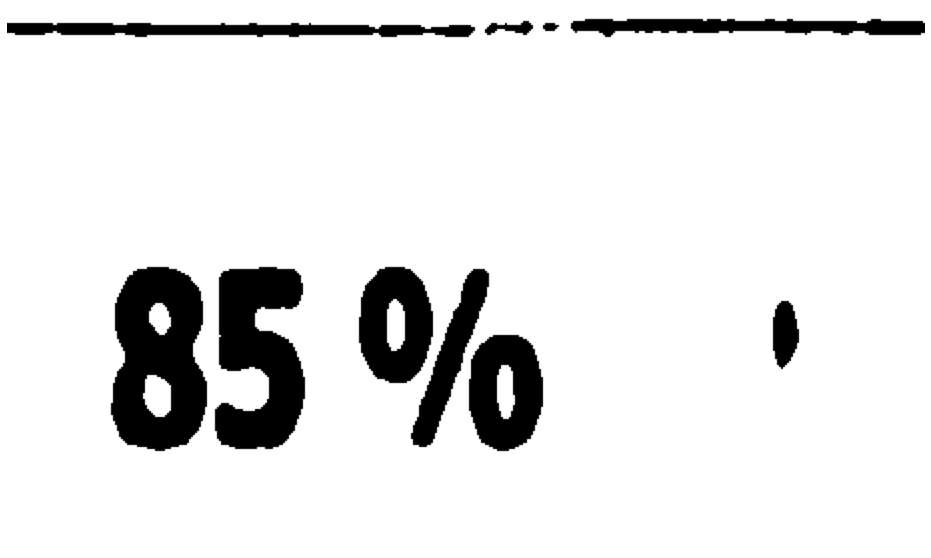

85% |



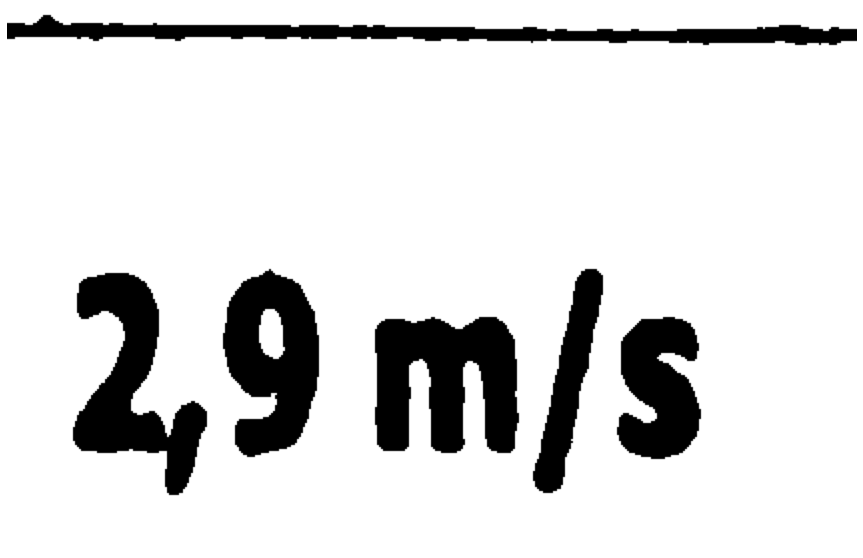

 

2,9 m/s



In [ ]:
x1 = int(((85/739) * dimensions['width']) // 1)
x1_add = int(((260/739) * dimensions['width']) // 1)

x2 = int(((230/739) * dimensions['width']) // 1)
x2_add = int(((250/739) * dimensions['width']) // 1)

y1 = int(((110/558) * dimensions['height']) // 1)
y1_add = int(((150/558) * dimensions['height']) // 1)

y2 = int(((160/558) * dimensions['height']) // 1)
y2_add = int(((160/558) * dimensions['height']) // 1)

for i in range(4):
  x1 = int(((85/739) * dimensions['width']) // 1)
  x2 = int(((230/739) * dimensions['width']) // 1)
  if i > 0:
    y1 = y1 + y1_add
    y2 = y2 + y2_add
  
  for j in range(4):
    if i == 0 and j == 3:
      break
    if i == 3 and j == 3:
      break
    if j > 0:
      x1 = x1 + x1_add
      x2 = x2 + x2_add

    janela=transform[y1:y2, x1:x2]
    janelaBW=cv2.cvtColor(janela, cv2.COLOR_BGR2GRAY)

    janelaBW = np.around((janelaBW-48)*1.4)
    janelaBW = janelaBW.astype(np.uint8)
    janela_processada = preprocessamento(janelaBW)
    mostrar(janela_processada)
    leitura = pytesseract.image_to_string(janela_processada)
    print(leitura)

(OCR funciona bem para o texto)

In [ ]:
'''
custom_oem = r'-c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyz --psm 6'
janela_processada = preprocessamento(janelaBW[1:50, 1:230])
mostrar(janelaBW[1:50, 1:230])
texto = pytesseract.image_to_string(janelaBW[1:50, 1:230],config=custom_oem)



#config_tesseract = "--tessdata-dir tessdata"
#texto = pytesseract.image_to_string(janela, lang="por", config=config_tesseract)
print(texto)
'''

(OCR apresentou problemas para interpretar o sinal negativo, daí a binarização ajudou)

In [ ]:
'''
janela_processada = preprocessamento(janelaBW[60:135, 55:220])
mostrar(janela_processada)
texto = pytesseract.image_to_string(janela_processada,config=custom_oem)
print(texto)
'''

'\njanela_processada = preprocessamento(janelaBW[60:135, 55:220])\nmostrar(janela_processada)\ntexto = pytesseract.image_to_string(janela_processada,config=custom_oem)\nprint(texto)\n'